# Task 2: Comparative Analysis of CNN and Vision Transformer on CIFAR-10 Image Classification

# Introduction

This notebook implements and evaluates both a Convolutional Neural Network (CNN) and Vision Transformer (ViT) for image classification on the CIFAR-10 dataset.
Both models will be trained on the same dataset under comparable conditions. The resulting accuracy, computational efficiency, and generalisation ability of each architecture will be analysed and compared, in order to draw insights into their respective strengths, weaknesses and differences in learning behaviours.

# Setup

### Settings for Reproducibility
To ensure reproducibility, the versions of python and PyTorch are reported below:
1. Python Version: 3.12.5
2. PyTorch Version: 2.5.1+cpu121

Disclaimer: While the seed is explicitly defined to ensure reproducibility, slight variations in the training results and various plots may still occur. These small differences are likely due to the specific hardware characteristics of the computer used, such as CPU and memory performance. We have minimized these discrepancies, but they may still be present. For reference on the exact output graphs used for our interpretations, please refer to the accompanying PDF document.

### Import Libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from PIL import Image
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import pytorch_lightning as pl
from pytorch_lightning import Trainer, LightningModule

# Device configuration (GPU support)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set pytorch lightning seed for reproducibility
pl.seed_everything(42, workers=True)

Seed set to 42


42

# Data Import and Preparation

The CIFAR-10 dataset consists of 60,000 RGB images, 50,000 in the training set and 10,000 in the test set. Each image is of size 32x32 pixels, with the pixel values normalised to [0, 1]. Each image has a label of 1 of 10 different classes, namely:

0. 'airplane'
1. 'automobile'
2. 'bird'
3. 'cat'
4. 'deer'
5. 'dog'
6. 'frog'
7. 'horse'
8. 'ship'
9. 'truck'

As part of our data preprocessing, we performed the following data augmentations on the CIFAR-10 dataset.

1. Flipping the images horizontally
2. Rotate images within +/- 15 degrees
3. Translate the images

These augmentations are useful for enabling computer vision models to generalise better to unseen data, as they learn to recognise the object regardless of the transformations made to them.

Additionally, since the pixel values of the images are in a [0, 1] scale, we further normalised the dataset using the channel-wise mean and standard deviation values, obtained by averaging across the entire CIFAR-10 dataset training images. This brings each RGB channel to mean = 0 and std dev = 1, thereby standardising the input in order to train the neural networks more effectively.

In [2]:
# Define transformations for the training set
# Includes data augmentation (flipping, rotation, translation) and normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(15),           # Rotate images randomly within ±15 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Apply random translations
    transforms.ToTensor(),                   # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize using CIFAR-10 stats
])
# Define transformations for the test set
# Only normalization is applied (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),                   # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize using CIFAR-10 stats
])

In [3]:
batch_size = 1024
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Visualise sample images from the test dataset

Sample transformed images from the training set:


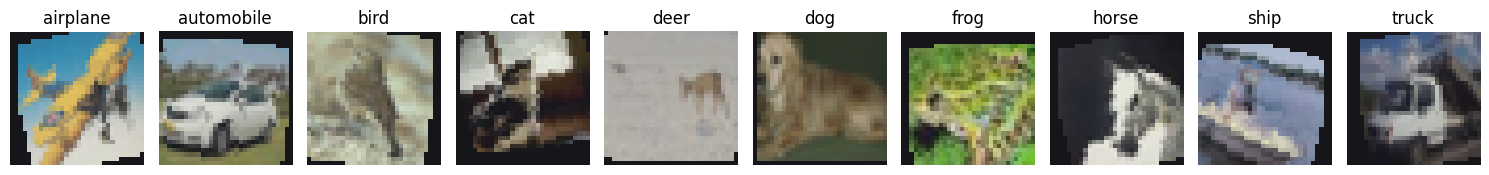

Sample images from the test set:


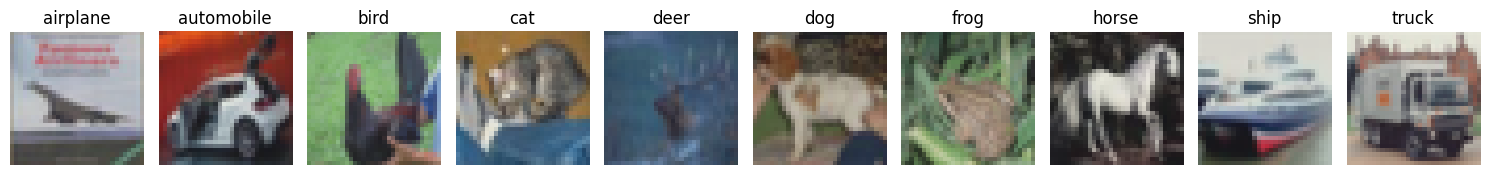

In [4]:
def visualize_sample_images(dataloader, class_names=None):
    found = {}
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            if label not in found:
                found[label] = img
            if len(found) == 10:
                break
        if len(found) == 10:
            break

    plt.figure(figsize=(15, 3))
    for idx, class_id in enumerate(sorted(found.keys())):
        img = found[class_id].cpu()
        img_np = img.permute(1, 2, 0).numpy()

        # Denormalize (CIFAR-10)
        img_np = img_np * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(1, 10, idx + 1)
        plt.imshow(img_np)
        plt.axis('off')
        if class_names:
            plt.title(class_names[class_id])
        else:
            plt.title(f"Class {class_id}")

    plt.tight_layout()
    plt.show()

print("Sample transformed images from the training set:")
visualize_sample_images(train_loader, class_names=classes)
print("Sample images from the test set:")
visualize_sample_images(test_loader, class_names=classes)

# Defining Model Architectures

### Convolutional Neural Network (CNN) Architecture
Our CNN architecture is implemented as follows:
- **Feature Extraction - 3x ResBlocks**
    - Each ResBlock contains 2 convolutional filters, BatchNorm, ReLU, and a residual connection added to the output.
    - Each filter has dimension of 3x3, and padding of 1 pixel is used to maintain the spatial dimensions of the input (i.e., the height and width of the image), since 32x32 is already very small.
    - The 1st filter performs a convolution on the input and splits it multiple feature maps. The 2nd filter performs another convolution without increasing the number of output feature maps.
    - We have noted that low resolution of the images makes it difficult to make out what the object in the images are. Hence, we made sure that the number of feature maps increases substantially with each ResBlock, from 3 RGB input channels -> 32 -> 64 -> 128.
    - Having a larger number of feature maps with each block of the CNN enables the model to capture a larger variety of abstract features, such as edges around the object or patterns of an animal, thus allowing the CNN to use more visual characteristics to differentiate between different classes more easily.
    - Batch normalisation is used to ensure numeric stability of the learned weights, especially with ReLU activation.
    - ReLU activation is used to introduce non-linearity to the model.
    - Residual connection adds the original input image to the output of the residual block. This is important for a dataset with low resolution images, as it preserves the original details of the image, which would have otherwise been lost due to the convolution. This also helps to address any vanishing gradient problems.
    - MaxPooling
        - Applied after each ResBlock to progressively downsample the image.
        - Although the spatial resolution of the images are lost from the act of downsampling, the most important 'meta' features of the image are preserved and carried forward to the next block of the CNN, rather than ensuring every pixel of the input is retained. This way, the CNN learns to recognise high level visual characteristics rather than individual pixels of the image.
        - Crucially, downsampling helps improve on computational efficiency of the CNN. In this case, the feature maps are shrunk from 32x32 → 16x16 → 8x8 → 4x4, which is effectively a substantial 64x reduction in computation needed in later layers.
    - Dropout
        - A low dropout rate of 0.1 was empirically tested and used to regularise the learning and prevent overfitting. A balance was achieved to prevent the model from underfitting as well.
- **MLP Layer**
    - Following the feature extraction, the output is flattened into a 128x4x4 = 2048 embedding and passed as input to a MLP layer of size 512.
    - This is followed by another MLP layer of size 10, corresponding to the 10 classes for final classification.
- **Input Batch Normalisation**
    - The model also includes batch normalization for the input image, labeled as self.whiten. This normalizes the input image's channels (RGB), potentially leading to better model performance by ensuring that the inputs have a mean of zero and a standard deviation of one.
- **He Kaiming Initialization**
    - Since the model utilises ReLU activations, He initialisation is best optimised for this.

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # First convolutional layer in the residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolutional layer in the residual block
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # If input and output dimensions differ, use a 1x1 convolution to match dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),  # 1x1 convolution
                nn.BatchNorm2d(out_channels)  # Batch normalization for the shortcut
            )

    def forward(self, x):
        residual = x  # Store the input for the shortcut connection
        x = self.relu(self.bn1(self.conv1(x)))  # Apply the first convolution, batch normalization, and ReLU activation
        x = self.bn2(self.conv2(x))  # Apply the second convolution and batch normalization
        x += self.shortcut(residual)  # Add the shortcut connection to the output
        return self.relu(x)  # Apply ReLU activation to the final output

class CNN(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(CNN, self).__init__()
        self.whiten = nn.BatchNorm2d(3, affine=True, track_running_stats=True) # Batch normalization for input channels (RGB)
        # Define the feature extraction layers
        # Modified feature extractor with residual blocks
        self.features = nn.Sequential(
            ResBlock(3, 32),          # 32x32x3 → 32x32x32
            nn.MaxPool2d(2),          # 32x32x32 → 16x16x32
            nn.Dropout(dropout_prob),
            
            ResBlock(32, 64),         # 16x16x32 → 16x16x64
            nn.MaxPool2d(2),          # 16x16x64 → 8x8x64
            nn.Dropout(dropout_prob),
            
            ResBlock(64, 128),        # 8x8x64 → 8x8x128
            nn.MaxPool2d(2),          # 8x8x128 → 4x4x128
            nn.Dropout(dropout_prob)
        )
        # Define the classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),     # Flattened input size: 128 * 4 * 4, Output size: 512
            nn.ReLU(),                       # Activation function
            nn.Dropout(dropout_prob),        # Dropout for regularization
            nn.Linear(512, 10)               # Output size: 10 (number of classes in CIFAR-10)
        )
        # Initialize weights for the layers
        self._initialize_weights()

    def forward(self, x):
        # Apply batch normalization (whitening) to the input
        x = self.whiten(x)
        # Pass input through the feature extraction layers
        x = self.features(x)
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        # Pass through the classifier
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        # Initialize weights for Conv2D and Linear layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He Kaiming initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)  # Initialize biases to 0
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)  # Initialize weights with normal distribution
                nn.init.constant_(m.bias, 0)       # Initialize biases to 0
    
    def visualise_feature_maps(self, img, layer_idx=0, num_channels=4):
        # Function to visualize feature maps from a specific layer
        input_tensor = img.unsqueeze(0)
        assert input_tensor.dim() == 4 and input_tensor.size(0) == 1, "Input must be a single image with shape [1, 3, H, W]"
        self.eval()

        # Pass the image through the network up to the specified layer
        with torch.no_grad():
            input_tensor = self.whiten(input_tensor)
            for i in range(layer_idx + 1):
                input_tensor = self.features[i](input_tensor)
        feature_map = input_tensor[0]  # shape: [C, H, W]

        # De-normalize original image for plotting
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])  # De-normalize
        img_np = np.clip(img_np, 0, 1)

        # Plot individual channels
        fig, axes = plt.subplots(1, 5, figsize=(12, 3))
        axes = axes.flatten()

        axes[0].imshow(img_np)  # Plot original image
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        for i in range(1, num_channels+1):  # Plot first 11 feature maps
            fmap = feature_map[i - 1].cpu().numpy()
            axes[i].imshow(fmap, cmap='inferno')
            axes[i].set_title(f'Feature {i}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

### Vision Transformer (ViT) Architecture
Our ViT architecture is implemented as follows:
- **Patch Embedding**
    - A Conv2D is used to perform both the patchification and embedding steps efficiently in a single step, significantly reducing the complexity of the patching process compared to a manual step.
    - The patching step involves splitting the 32x32 image into 64 non-overlapping patches of size 4x4. This is achieved using a filter size and stride of 4. By setting the kernel size and stride both to 4, the patches are non-overlapping, meaning that the entire image is divided into equal-sized patches without any loss or overlap between patches. This is crucial to preserve the spatial resolution of the image when learning embeddings.
    - The embedding step involves transforming each of the 64 patches into an embedding vector of length 128. This is achieved by applying 128 filters over the input, effectively projecting each patch into a 1D vector.
    - Effectively, the transformer model learns to embed the multiple patches of the image into a semantic space, where each patch carries semantic meaning understood by the model.
    - A Classify token (CLS) is initialised at the front of the sequence of patch embeddings, acting as the final embedding of all the information of the image for classification.
    - A learnable positional embedding is also randomly initialised.
- **Positional Embedding**
    - Positional embeddings are added to the patch embeddings, as they hold the spatial information of each patch relative to the others. This is an important step following the patch splitting, which had previously discarded the positional information of the patches. This way, the attention model is able to learn the relative positions of each patch, in addition to the semantic information of each patch.
    - We opted to use learnable positional embeddings, rather than fixed sinusoidal embeddings, as this would be more flexible for the model to semantically learn the relative positions of each patch in the image, rather than defining it for the model.
- **Transformer Encoder**
    - Multi-Head Attention
        - Multi-head attention (MHA) is used instead of single-head attention as it allows the model to split its focus into multiple perspectives over each patch embedding. Intuitively, it allows the model to analyse different parts or characteristics of the image.
        - 4 attention heads were selected for this model. Although increasing the number of attention heads allows for more diverse perspectives that lead to a richer contextual output, this significantly increased the computational cost of the training, and hence 4 attention heads achieved the desired balance of performance and computational efficiency.
    - LayerNorm
        - Used to ensure numeric stability in the learned weights, similar to the BatchNorm used in the CNN architecture.
    - MLP block
        - A 2-layer MLP block is used to process the embeddings, with a GELU activation function used to introduce non-linearity. GELU is used as it has been shown to outperform ReLU in transformer models.
    - Dropout
        - A low dropout rate of 0.1 was empirically tested and used to regularise the learning and reduce overfitting. A balance was achieved to prevent the model from underfitting as well.
    - Residual Connections
        - As per standard transformer architecture, 2 residual connections are used, 1 after the MHA followed by 1 after the MLP block. This helps to avoid the vanishing gradients problem.
    - Depth
        - 6 transformer layers are used, with each layer further refining the patch and CLS embeddings by learning more abstract information in the image, but not too deep to prevent overfitting.
- **CLS Token**
    -  Extracted from the output and returned for final classification.

In [ ]:
# ViT Architecture
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=128):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2  # Calculate the number of patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1, 2)   # Perform patchification and embedding in one step using Conv2d
        cls_tokens = self.cls_token.expand(B, 1, -1)  # Initialise CLS token
        x = torch.cat((cls_tokens, x), dim=1)         # Prepending the CLS token
        x = x + self.pos_embed                        # Adding positional embedding to patch embedding
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)  # 1st LayerNorm
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)  # Multihead Attention
        self.norm2 = nn.LayerNorm(embed_dim)  # 2nd LayerNorm
        self.mlp = nn.Sequential(  # 2-layer MLP using GELU activation
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_attention=False):
        normed = self.norm1(x)
        attn_out, attn_weights = self.attn(normed, normed, normed, # passing in Query, Key, Value tensors
                                           need_weights=return_attention, # return weights for visualisation
                                           average_attn_weights=False) # to inspect each head's weights
        x = x + self.dropout(attn_out)  # 1st residual connection
        x = x + self.dropout(self.mlp(self.norm2(x)))  # 2nd residual connection

        if return_attention:
            return x, attn_weights
        return x

class ViT(nn.Module):
    def __init__(self, num_classes=10, img_size=32, patch_size=4, embed_dim=128, depth=6, num_heads=4, mlp_dim=512):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoder(embed_dim, num_heads, mlp_dim) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x) # Perform patch embedding
        x = self.encoder(x)     # Perform Transformer encoding
        x = self.norm(x[:, 0])  # Return only the CLS token
        return self.head(x)
    
    def visualise_attention_overlay(self, img, head=None):  # Visualise attention heads from last encoder layer
        self.eval()
        device = next(self.parameters()).device

        input_tensor = img.unsqueeze(0)

        with torch.no_grad():
            embedding = self.patch_embed(input_tensor)  # [1, N+1, E]
            for layer in self.encoder[:-1]:
                embedding = layer(embedding)

            embedding, attn_weights = self.encoder[-1](embedding, return_attention=True)  # [1, heads, N+1, N+1]

        # Get CLS token attention weights to all patches from all heads
        if head is not None:
            cls_attn = attn_weights[0, head, 0, 1:]
        else:    
            cls_attn = attn_weights[0, :, 0, 1:].mean(dim=0)  # shape: [num_patches]

        patch_dim = int((embedding.shape[1] - 1) ** 0.5)
        attn_map = cls_attn.reshape(patch_dim, patch_dim).unsqueeze(0).unsqueeze(0)
        attn_map = F.interpolate(attn_map, size=(32, 32), mode='bilinear', align_corners=False)[0, 0]

        # De-normalize original image for plotting
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])  # De-normalize
        img_np = np.clip(img_np, 0, 1)

        # Prepare overlay with attention map
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))

        # Plot original image
        axes[0].imshow(img_np)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Image + attention overlay
        axes[1].imshow(img_np)
        axes[1].imshow(attn_map.cpu(), cmap='jet', alpha=0.5, extent=(0, 32, 32, 0))
        axes[1].set_title("Attention Overlay (Head {})".format(head+1 if head is not None else "All Heads"))
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Training Workflow

We have opted to use Pytorch Lightning to streamline our training process:
1. Performing forward pass
2. Defining the loss function
    - Since this is a multi-class classification task, the crossentropy loss function should be used as it penalises incorrect predictions more harshly when the model is confident.
3. Tracking the average training and validation losses and accuracies per epoch for loss and accuracy curve visualisations.
4. Hyperparameter tuning
    - Optimizer
        - AdamW Optimizer was used with a weight decay of 0.05, penalising overly large weights to prevent overfitting and help generalise better.
    - Learning rate
        - Empirically tested different learning rates, and eventually found a value of 1e-3 to be optimal for both models.
        - Cosine learning rate decay was used to gradually reduce the learning rate over time and achieve smoother convergence.
    - Max epochs
        - Empirically tested different training durations, and eventually found 80 epochs gave both models sufficient time to reach convergence.

In [7]:
# Defining Pytorch Lightning Classifier that will handle training and validation
class Classifier(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, model=None, criterion=None):
        super().__init__()
        self.model = model
        self.lr = learning_rate
        self.criterion = criterion

        # Store loss and accuracy metrics for training and validation
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []

        self._epoch_train_loss = []
        self._epoch_train_acc = []
        self._epoch_val_loss = []
        self._epoch_val_acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()

        # Store per-step metrics
        self._epoch_train_loss.append(loss.item())
        self._epoch_train_acc.append(acc.item())

        return loss
    
    def on_train_epoch_end(self):
        # Log average metrics of the epoch
        avg_loss = sum(self._epoch_train_loss) / len(self._epoch_train_loss)
        avg_acc = sum(self._epoch_train_acc) / len(self._epoch_train_acc)

        self.train_loss.append(avg_loss)
        self.train_acc.append(avg_acc)

        print(f"Epoch {self.current_epoch + 1} - Train Loss: {avg_loss:.4f}, "
              f"Train Acc: {avg_acc:.4f}")
        
        self._epoch_train_loss = []
        self._epoch_train_acc = []

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()

        # Store metrics per batch
        self._epoch_val_loss.append(loss.item())
        self._epoch_val_acc.append(acc.item())

        return loss

    def on_validation_epoch_end(self):
        # Log average metrics of the epoch
        avg_loss = sum(self._epoch_val_loss) / len(self._epoch_val_loss)
        avg_acc = sum(self._epoch_val_acc) / len(self._epoch_val_acc)

        self.val_loss.append(avg_loss)
        self.val_acc.append(avg_acc)

        self._epoch_val_loss = []
        self._epoch_val_acc = []

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=0.05, fused=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }

# Testing Workflow

In [8]:
# Generate predictions on test dataset
def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)  # [batch_size, num_classes]
            _, preds = torch.max(outputs, 1)  # get predicted class index

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

# Print metrics
def print_class_metrics(true_labels, pred_labels, class_names):
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Convert to NumPy arrays
    true_labels = true_labels.numpy() if hasattr(true_labels, 'numpy') else np.array(true_labels)
    pred_labels = pred_labels.numpy() if hasattr(pred_labels, 'numpy') else np.array(pred_labels)

    # Print classification report
    report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

    print(f"\n{'Class':<15}{'Precision':>10}{'Recall':>10}{'F1-Score':>12}{'Accuracy':>12}")
    print("-" * 60)

    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']

        # Per-class accuracy = correct predictions / total for that class
        class_accuracy = cm[i, i] / cm[i].sum()

        print(f"{class_name:<15}{precision:10.4f}{recall:10.4f}{f1:12.4f}{class_accuracy:12.4f}")

    overall_accuracy = (pred_labels == true_labels).mean()
    print(f"\nOverall accuracy: {overall_accuracy:41.4f}")

# Plot loss and accuracy curves
def plot_curves(classifier, name=None):
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(classifier.train_loss, label='Train Loss')
    plt.plot(classifier.val_loss, label='Validation Loss')
    plt.title(f"{name} Loss Curve")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(classifier.train_acc, label='Train Accuracy')
    plt.plot(classifier.val_acc, label='Validation Accuracy')
    plt.title(f"{name} Accuracy Curve")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# CNN implementation

### Training Phase

In [9]:
# Creating PyTorch Lightning Classifier instances for CNN
cnn_classifier = Classifier(learning_rate=1e-3,
                               model=CNN().to(device),
                               criterion=nn.CrossEntropyLoss()
                               )

# Creating a PyTorch Lightning Trainer instance for training
cnn_trainer = Trainer(
    max_epochs=80,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None
)

# Train the CNN model
start_time = time.time()  # Record time taken for training
cnn_trainer.fit(cnn_classifier, train_loader, test_loader)
end_time = time.time()
cnn_train_time = end_time - start_time

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | CNN              | 1.4 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.7407, Train Acc: 0.3588


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.3449, Train Acc: 0.5054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.1735, Train Acc: 0.5748


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.0652, Train Acc: 0.6161


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.9751, Train Acc: 0.6500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.9203, Train Acc: 0.6723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.8599, Train Acc: 0.6935


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.8194, Train Acc: 0.7075


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.7930, Train Acc: 0.7175


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.7547, Train Acc: 0.7321


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.7259, Train Acc: 0.7436


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.7070, Train Acc: 0.7484


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.6899, Train Acc: 0.7540


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.6668, Train Acc: 0.7654


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.6539, Train Acc: 0.7700


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 - Train Loss: 0.6318, Train Acc: 0.7773


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.6169, Train Acc: 0.7829


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.6026, Train Acc: 0.7867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.5879, Train Acc: 0.7926


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.5762, Train Acc: 0.7975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 - Train Loss: 0.5656, Train Acc: 0.7998


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 - Train Loss: 0.5529, Train Acc: 0.8049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 - Train Loss: 0.5401, Train Acc: 0.8120


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 - Train Loss: 0.5283, Train Acc: 0.8149


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 - Train Loss: 0.5170, Train Acc: 0.8148


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 - Train Loss: 0.5096, Train Acc: 0.8208


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 - Train Loss: 0.5076, Train Acc: 0.8201


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 - Train Loss: 0.4927, Train Acc: 0.8246


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 - Train Loss: 0.4849, Train Acc: 0.8307


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 - Train Loss: 0.4763, Train Acc: 0.8306


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 - Train Loss: 0.4698, Train Acc: 0.8324


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 - Train Loss: 0.4686, Train Acc: 0.8348


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 - Train Loss: 0.4565, Train Acc: 0.8388


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 - Train Loss: 0.4510, Train Acc: 0.8413


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 - Train Loss: 0.4373, Train Acc: 0.8468


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 - Train Loss: 0.4365, Train Acc: 0.8440


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37 - Train Loss: 0.4276, Train Acc: 0.8491


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38 - Train Loss: 0.4259, Train Acc: 0.8490


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39 - Train Loss: 0.4195, Train Acc: 0.8519


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 - Train Loss: 0.4148, Train Acc: 0.8539


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41 - Train Loss: 0.4099, Train Acc: 0.8542


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42 - Train Loss: 0.4029, Train Acc: 0.8574


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43 - Train Loss: 0.3989, Train Acc: 0.8601


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44 - Train Loss: 0.3955, Train Acc: 0.8598


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 - Train Loss: 0.3843, Train Acc: 0.8635


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46 - Train Loss: 0.3830, Train Acc: 0.8675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47 - Train Loss: 0.3786, Train Acc: 0.8654


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48 - Train Loss: 0.3720, Train Acc: 0.8685


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49 - Train Loss: 0.3716, Train Acc: 0.8687


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50 - Train Loss: 0.3679, Train Acc: 0.8697


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51 - Train Loss: 0.3607, Train Acc: 0.8715


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52 - Train Loss: 0.3552, Train Acc: 0.8737


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53 - Train Loss: 0.3556, Train Acc: 0.8740


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54 - Train Loss: 0.3476, Train Acc: 0.8769


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55 - Train Loss: 0.3449, Train Acc: 0.8789


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56 - Train Loss: 0.3448, Train Acc: 0.8768


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57 - Train Loss: 0.3417, Train Acc: 0.8781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58 - Train Loss: 0.3358, Train Acc: 0.8813


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59 - Train Loss: 0.3371, Train Acc: 0.8794


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60 - Train Loss: 0.3303, Train Acc: 0.8823


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61 - Train Loss: 0.3335, Train Acc: 0.8813


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62 - Train Loss: 0.3292, Train Acc: 0.8811


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63 - Train Loss: 0.3279, Train Acc: 0.8829


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64 - Train Loss: 0.3264, Train Acc: 0.8834


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65 - Train Loss: 0.3190, Train Acc: 0.8874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66 - Train Loss: 0.3213, Train Acc: 0.8848


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67 - Train Loss: 0.3152, Train Acc: 0.8888


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68 - Train Loss: 0.3150, Train Acc: 0.8894


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69 - Train Loss: 0.3147, Train Acc: 0.8888


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70 - Train Loss: 0.3130, Train Acc: 0.8908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71 - Train Loss: 0.3117, Train Acc: 0.8891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72 - Train Loss: 0.3084, Train Acc: 0.8907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73 - Train Loss: 0.3119, Train Acc: 0.8891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74 - Train Loss: 0.3075, Train Acc: 0.8920


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75 - Train Loss: 0.3113, Train Acc: 0.8895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76 - Train Loss: 0.3115, Train Acc: 0.8898


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77 - Train Loss: 0.3089, Train Acc: 0.8906


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78 - Train Loss: 0.3082, Train Acc: 0.8914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79 - Train Loss: 0.3063, Train Acc: 0.8926


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80 - Train Loss: 0.3108, Train Acc: 0.8890


### Testing, Metrics & Visualisations

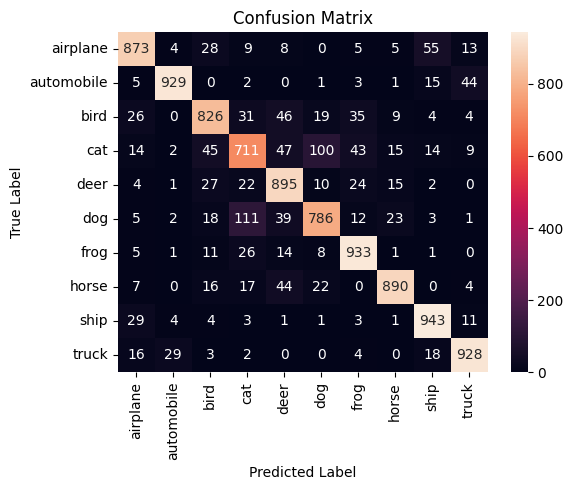


Class           Precision    Recall    F1-Score    Accuracy
------------------------------------------------------------
airplane           0.8872    0.8730      0.8800      0.8730
automobile         0.9558    0.9290      0.9422      0.9290
bird               0.8446    0.8260      0.8352      0.8260
cat                0.7612    0.7110      0.7353      0.7110
deer               0.8181    0.8950      0.8548      0.8950
dog                0.8300    0.7860      0.8074      0.7860
frog               0.8785    0.9330      0.9049      0.9330
horse              0.9271    0.8900      0.9082      0.8900
ship               0.8938    0.9430      0.9178      0.9430
truck              0.9152    0.9280      0.9215      0.9280

Overall accuracy:                                    0.8714


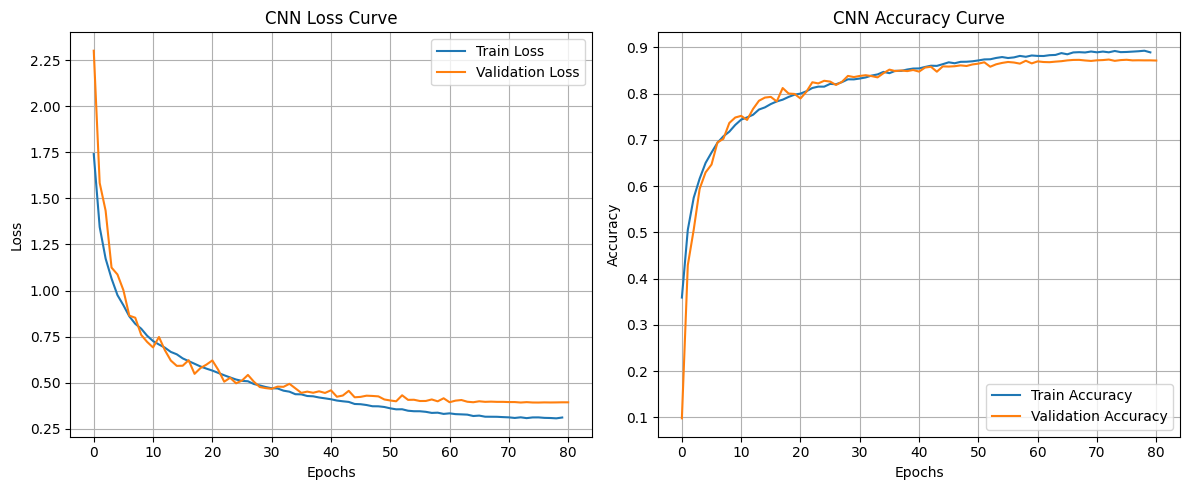

Time taken to train CNN: 1127.00 seconds


In [10]:
# Generate predictions for CNN model
predictions_cnn, labels_cnn = predict(cnn_classifier.model, test_loader, cnn_classifier.device)

# Print metrics, loss and accuracy curves for CNN model
print_class_metrics(labels_cnn, predictions_cnn, classes)
plot_curves(cnn_classifier, name='CNN')
print(f"Time taken to train CNN: {cnn_train_time:.2f} seconds")

### Visualise Sample Feature Maps

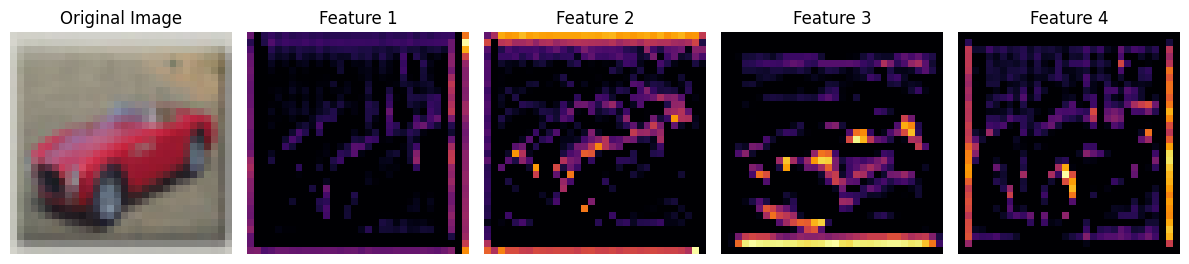

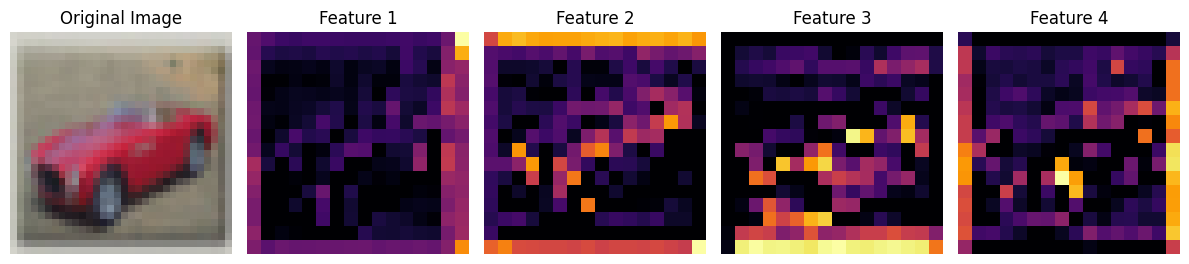

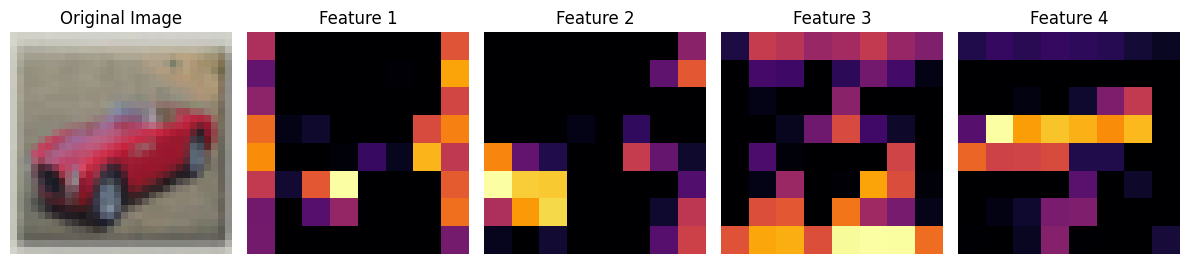

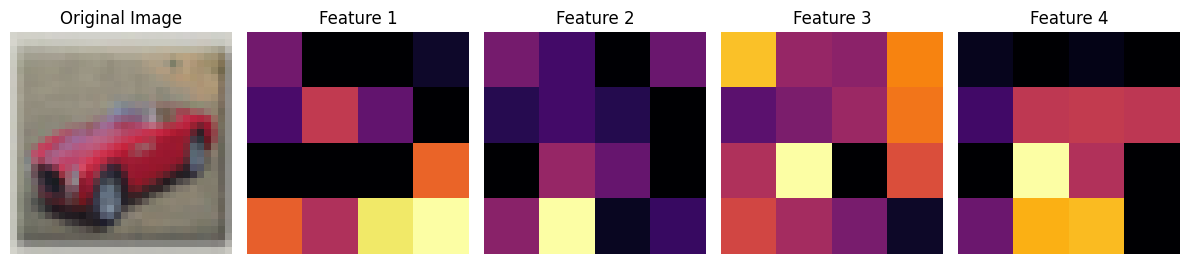

In [56]:
# Get one image from the training set
img = test_dataset[1234][0]

# Call the visualisation function to see feature maps
cnn_classifier.model.visualise_feature_maps(img, layer_idx=0, num_channels=4)
cnn_classifier.model.visualise_feature_maps(img, layer_idx=1, num_channels=4)
cnn_classifier.model.visualise_feature_maps(img, layer_idx=4, num_channels=4)
cnn_classifier.model.visualise_feature_maps(img, layer_idx=7, num_channels=4)

# ViT implementation

### Training Phase

In [12]:
# Creating PyTorch Lightning Classifier instances for ViT
vit_classifier = Classifier(learning_rate=1e-3,
                               model=ViT().to(device),
                               criterion=nn.CrossEntropyLoss()
                               )

# Creating a PyTorch Lightning Trainer instance for training
vit_trainer = Trainer(
    max_epochs=80,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None
)

# Train the ViT model
start_time = time.time()  # Record time taken for training
vit_trainer.fit(vit_classifier, train_loader, test_loader)
end_time = time.time()
vit_train_time = end_time - start_time

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ViT              | 1.2 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.824     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (49) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Train Loss: 2.0774, Train Acc: 0.2286


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.7724, Train Acc: 0.3473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.5595, Train Acc: 0.4327


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.4607, Train Acc: 0.4710


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3891, Train Acc: 0.4952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Train Loss: 1.3285, Train Acc: 0.5201


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Train Loss: 1.2870, Train Acc: 0.5376


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Train Loss: 1.2378, Train Acc: 0.5528


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - Train Loss: 1.2156, Train Acc: 0.5626


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 - Train Loss: 1.1745, Train Acc: 0.5790


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 - Train Loss: 1.1529, Train Acc: 0.5868


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 - Train Loss: 1.1246, Train Acc: 0.5976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 - Train Loss: 1.0918, Train Acc: 0.6114


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 - Train Loss: 1.0608, Train Acc: 0.6218


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 - Train Loss: 1.0350, Train Acc: 0.6294


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 - Train Loss: 1.0099, Train Acc: 0.6406


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.9914, Train Acc: 0.6473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.9697, Train Acc: 0.6533


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.9454, Train Acc: 0.6631


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.9264, Train Acc: 0.6720


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 - Train Loss: 0.9014, Train Acc: 0.6799


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 - Train Loss: 0.9042, Train Acc: 0.6795


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 - Train Loss: 0.8701, Train Acc: 0.6908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 - Train Loss: 0.8558, Train Acc: 0.6959


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 - Train Loss: 0.8387, Train Acc: 0.7020


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 - Train Loss: 0.8195, Train Acc: 0.7085


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 - Train Loss: 0.8036, Train Acc: 0.7150


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 - Train Loss: 0.7840, Train Acc: 0.7235


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 - Train Loss: 0.7794, Train Acc: 0.7212


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 - Train Loss: 0.7643, Train Acc: 0.7281


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 - Train Loss: 0.7482, Train Acc: 0.7346


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 - Train Loss: 0.7415, Train Acc: 0.7363


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 - Train Loss: 0.7223, Train Acc: 0.7441


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 - Train Loss: 0.7035, Train Acc: 0.7505


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 - Train Loss: 0.6813, Train Acc: 0.7572


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 - Train Loss: 0.6750, Train Acc: 0.7590


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37 - Train Loss: 0.6611, Train Acc: 0.7644


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38 - Train Loss: 0.6494, Train Acc: 0.7667


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39 - Train Loss: 0.6317, Train Acc: 0.7764


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 - Train Loss: 0.6255, Train Acc: 0.7771


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41 - Train Loss: 0.6111, Train Acc: 0.7836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42 - Train Loss: 0.5949, Train Acc: 0.7876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43 - Train Loss: 0.5850, Train Acc: 0.7922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44 - Train Loss: 0.5755, Train Acc: 0.7953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 - Train Loss: 0.5650, Train Acc: 0.7989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46 - Train Loss: 0.5503, Train Acc: 0.8020


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47 - Train Loss: 0.5351, Train Acc: 0.8086


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48 - Train Loss: 0.5240, Train Acc: 0.8144


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49 - Train Loss: 0.5103, Train Acc: 0.8182


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50 - Train Loss: 0.5062, Train Acc: 0.8186


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51 - Train Loss: 0.4926, Train Acc: 0.8227


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52 - Train Loss: 0.4798, Train Acc: 0.8299


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53 - Train Loss: 0.4758, Train Acc: 0.8293


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54 - Train Loss: 0.4631, Train Acc: 0.8332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55 - Train Loss: 0.4516, Train Acc: 0.8383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56 - Train Loss: 0.4411, Train Acc: 0.8427


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57 - Train Loss: 0.4316, Train Acc: 0.8469


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58 - Train Loss: 0.4285, Train Acc: 0.8468


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59 - Train Loss: 0.4235, Train Acc: 0.8499


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60 - Train Loss: 0.4132, Train Acc: 0.8510


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61 - Train Loss: 0.3993, Train Acc: 0.8560


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62 - Train Loss: 0.3996, Train Acc: 0.8569


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63 - Train Loss: 0.3922, Train Acc: 0.8605


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64 - Train Loss: 0.3819, Train Acc: 0.8646


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65 - Train Loss: 0.3751, Train Acc: 0.8655


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66 - Train Loss: 0.3732, Train Acc: 0.8667


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67 - Train Loss: 0.3723, Train Acc: 0.8657


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68 - Train Loss: 0.3652, Train Acc: 0.8709


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69 - Train Loss: 0.3631, Train Acc: 0.8698


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70 - Train Loss: 0.3564, Train Acc: 0.8737


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71 - Train Loss: 0.3558, Train Acc: 0.8741


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72 - Train Loss: 0.3489, Train Acc: 0.8739


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73 - Train Loss: 0.3505, Train Acc: 0.8745


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74 - Train Loss: 0.3481, Train Acc: 0.8766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75 - Train Loss: 0.3460, Train Acc: 0.8764


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76 - Train Loss: 0.3441, Train Acc: 0.8767


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77 - Train Loss: 0.3436, Train Acc: 0.8762


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78 - Train Loss: 0.3436, Train Acc: 0.8790


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79 - Train Loss: 0.3409, Train Acc: 0.8783


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80 - Train Loss: 0.3386, Train Acc: 0.8791


### Testing, Metrics & Visualisations

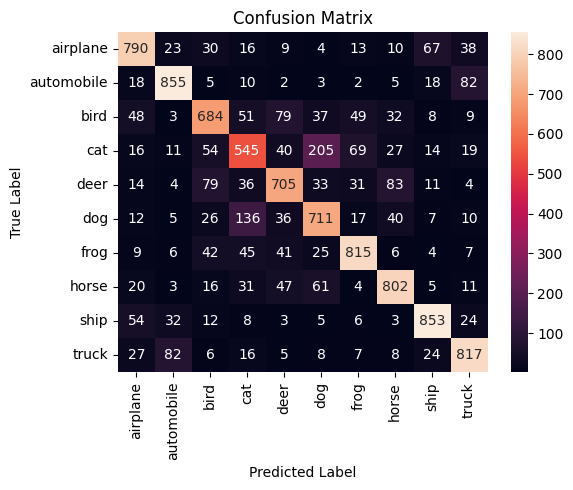


Class           Precision    Recall    F1-Score    Accuracy
------------------------------------------------------------
airplane           0.7837    0.7900      0.7869      0.7900
automobile         0.8350    0.8550      0.8449      0.8550
bird               0.7170    0.6840      0.7001      0.6840
cat                0.6096    0.5450      0.5755      0.5450
deer               0.7291    0.7050      0.7168      0.7050
dog                0.6511    0.7110      0.6797      0.7110
frog               0.8045    0.8150      0.8097      0.8150
horse              0.7894    0.8020      0.7956      0.8020
ship               0.8437    0.8530      0.8483      0.8530
truck              0.8002    0.8170      0.8085      0.8170

Overall accuracy:                                    0.7577


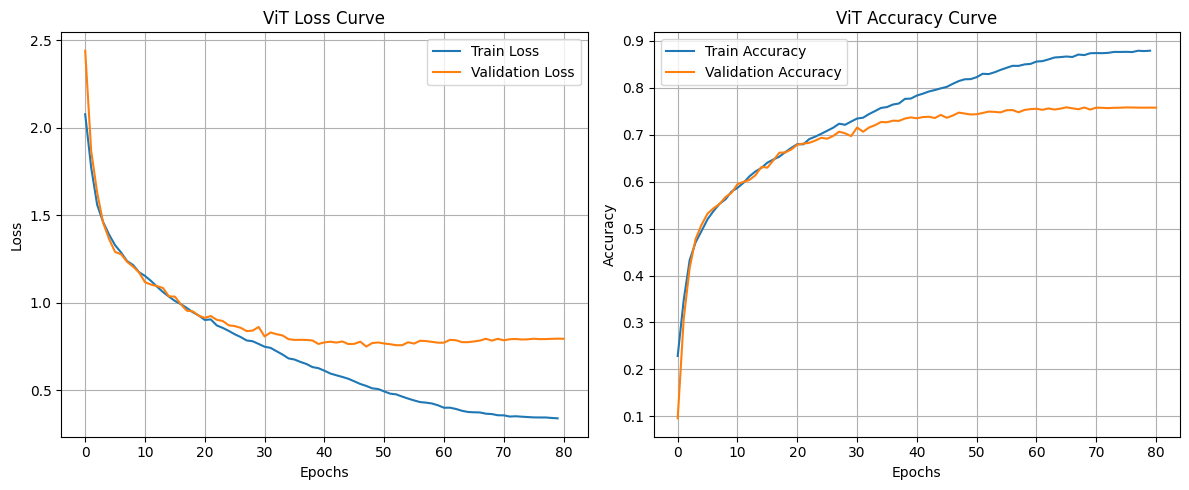

Time taken to train ViT: 1604.47 seconds


In [13]:
# Generate predictions for ViT model
predictions_vit, labels_vit = predict(vit_classifier.model, test_loader, vit_classifier.device)

# Print metrics, loss and accuracy curves for ViT model
print_class_metrics(labels_vit, predictions_vit, classes)
plot_curves(vit_classifier, name='ViT')
print(f"Time taken to train ViT: {vit_train_time:.2f} seconds")

### Visualise Attention Overlay

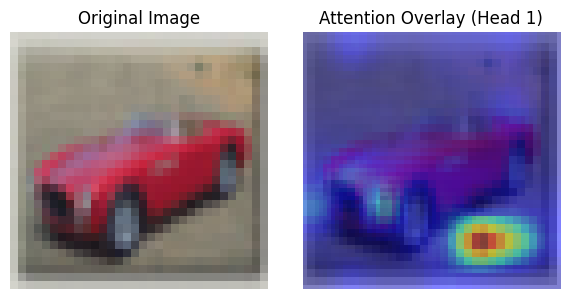

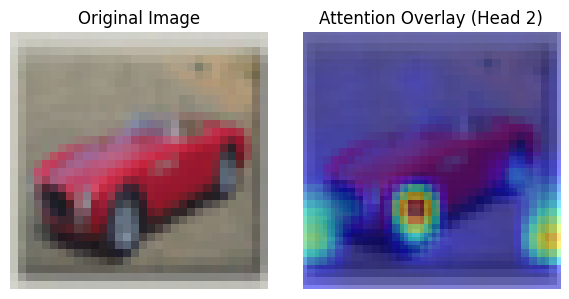

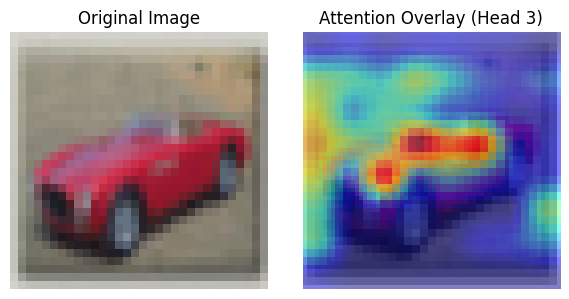

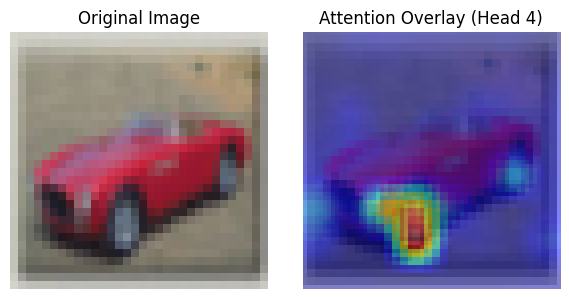

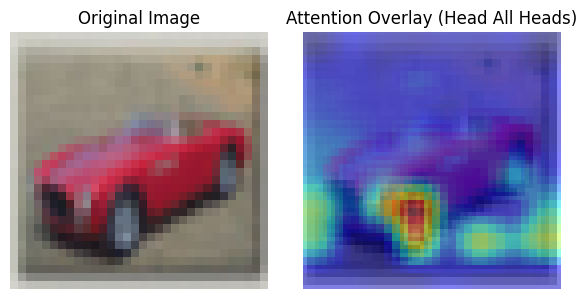

In [55]:
# Get one image from the training set
img = test_dataset[1234][0]

# Call the visualisation function to see attention overlay
vit_classifier.model.visualise_attention_overlay(img, head=0)
vit_classifier.model.visualise_attention_overlay(img, head=1)
vit_classifier.model.visualise_attention_overlay(img, head=2)
vit_classifier.model.visualise_attention_overlay(img, head=3)
vit_classifier.model.visualise_attention_overlay(img, head=None)  # Average attention across all heads

# Analysis

### 1. Performance Comparison
**Accuracy**
- The CNN architecture achieved a higher overall accuracy of 87.14% compared to the ViT architecture's overall accuracy of 75.77%. Moreover, the CNN had achieved a better score in virtually every metric (precision, recall, F1, accuracy) for every single class. This can be confirmed from the CNN confusion matrix, which shows a higher number of True Positives for every single class as compared to the ViT confusion matrix.
- As a sidenote, the common misclassifications by both models can be clustered into 2 broad categories: animals and vehicles. Concretely, the models tend to make misclassifications between 2 different classes of animals or 2 different classes of vehicles, but rarely between an animal and a vehicle, e.g. mistaking a bird for a car, although the bird tends to be mistaken for a plane at times. This is to be expected, since these 2 'meta' groups of classes are visually and conceptually very distinct. It can also be noted that the main confusion is between the 'cat' and 'dog' classes, which is reasonable since they both look visually very similar and the resolution of the dataset makes it harder to discern their features.

**Training Speed & Computational Efficiency**
- The CNN takes much less time (~ 19 mins) to train compared to the (~ 27 mins) ViT. This is surprising at first glance, considering that the CNN has slightly more parameters (1.4 mil) compared to the ViT (1.2 mil). This faster training speed and efficiency can be attributed to the respective architectures of the CNN and ViT.
- The CNN's inherent spatial hierarchy reduces computational complexity through progressive downsampling. Furthermore, CNNs demonstrate superior computational efficiency due to parameter sharing in convolutional layers, by using the same filter over the entire image.
- On the other hand, the ViT utilises multi-head attention whereby every patch pays attention to every other patch in the image. This becomes highly memory-demanding, especially with larger batch sizes, making inherently slower per epoch.

**Generalisation**
- Overall, based on the loss curves observed, the CNN demonstrates very good generalisation, while the ViT demonstrates rather poor generalisation. This will be further elaborated in the loss curve analysis below.
- As a side observation, the ViT performed even worse at roughly 60% test accuracy when an unaugmented train loader was used for our initial trial runs. Meanwhile, train accuracy remained high, showing a case of severe overfitting. Upon performing the various augmentations to the train data loader, the ViT's accuracy made a dramatic improvement to 75%. This strongly suggests that ViTs have generalisation potential by introducing random noise to the image, which forces the ViT to learn that even if the object is rotated or flipped, it still remains the same object.

### 2. Learning Behaviour Comparison
**Loss & Accuracy Curves**
- CNN
    - The training and validation loss curves both drop steadily and converge well, with the validation loss being just slightly higher than the training loss.
    - The training and validation accuracy curves follow a similar trend, rising steadily before converging above 85%, with the validation accuracy being just slightly lower than the training accuracy.
    - The relatively small gap between the training and validation curves for both loss and accuracy shows that there is minimal overfitting, and the model is able to generalise well to unseen data.
- ViT
    - The training and validation loss curves appear to drop more slowly than those of the CNN. This can be noted from how the loss curves only dip below crossentropy loss of 1.0 after epoch 15, as compared to CNN after epoch 5. The training loss curve continues to decrease gradually to 0.3386 (still slightly higher than CNN training loss curve reaching 0.3105), and appears to be decreasing still. Meanwhile, the validation loss began to converge much earlier around epoch 40 and remains significantly higher than training loss.
    - Similarly, the training and validation accuracy curves also rose more slowly, crossing 70% accuracy after 20+ epochs while it only took 5+ epochs for the CNN. Validation accuracy also begins to plateau around 75% after 40 epochs, while training accuracy continues to rise steadily close to 90%.
    - This wide gap between the training and validation curves for both loss and accuracy shows that there is clear overfitting, and there is much room to improve the ViT's generalisation.

**Feature Maps vs Attention Maps**
- CNN feature maps
    - We plotted a total of 16 feature map samples of a red car image from the test set. Each row of feature maps corresponds to the output of a ResBlock layer of the CNN, the top row being the earliest layer.
    - Starting from the top, the feature maps appear more detailed, retaining the 32x32 dimensions of the original image. This is because the output of the ResBlock occurs before the first MaxPooling.
    - Different patterns can be observed in each feature map. For example, some feature maps have learned to identify only diagonal streaks across the surface of the car, or only vertical edges of the car, or just the outline of the car. This reveals how each filter has learned to identify a particular characteristic in the image through the training of the neural network.
    - Additionally, some of the feature maps appear to have brighter pixel highlights in them. This is probably because the original image consisting of 3 RGB channels is taken as input into the first ResBlock. As such, not only can the filters capture spatial patterns, but they are sensitive to colour as well.
    - Going further down the rows, the feature maps appear more low-resolution and abstract. For example, the outputs in the last row are completely unrecognisable to the human eye. This is the result of repeated maxpoolings performed that downsample and only preserve the most important characteristics of each feature map.
    - Given the CNN architecture that starts with 32 feature maps after the first layer and 128 feature maps in the final layer, this means that the model has learned to capture 128 high-level features within the image, instead of learning the weights for every single pixel like in a fully-connected MLP.
    - In conclusion, the CNN learns certain visual patterns associated with different classes of images, and utilises feature maps to capture these patterns in order to identify the image class.
- ViT attention maps
    - We plotted a total of 5 attention overlay maps, the first 4 corresponding to each of the 4 attention heads, and the last being the aggregated attention maps across all 4 heads.
    - It can be observed from the attention overlays that the more intense red spots correspond to regions where the head focused its attention on.
    - It is noticed that the attention heads tend to pay attention to the body of the car, rather than the background. This shows that the model has understood the focus subject of the image should be the car, and ignores less relevant aspects of the image like the background that may not contribute as much to the model's classification.
    - It is also noted that each individual attention head is able to focus on and identify unique features of the car (e.g. the wheels) even when not explicitly taught what that part is. This shows how each attention head hold a different perspective of the image, which get aggregated to give the transformer a holistic contextual understanding of the image. This is much like how humans are able to identify objects based on discrete parts of the object, such as recognising a car by identifying its wheels, headlights and car doors.
    - Furthermore, the ability to pinpoint the location of various car parts within the picture goes to show the importance of the positional embeddings learned in the model. This means that the model has also learned the relative positions of different parts of the object within an image, which would aid in its recognition ability.

**Differences in learning behaviour**
- Each visualisation type (CNN feature maps vs ViT attention maps) reveals how the different models adopt different approaches to gain semantic understanding of images
- Feature maps show how CNNs deconstruct an image into its visual characteristics and patterns, and pays little regard to the position of the feature in the image. This is because the same filter is applied across the entire image, so it is not concerned about where the feature is, but only whether it exists.
- In contrast, attention maps show how ViTs specifically learn the positions and relationships between different image patches using attention mechanism and positional embeddings.
- The trends observed in the loss and accuracy curves point to the better generalisation of the CNN compared to the ViT on the CIFAR-10 dataset. However, ViT training curves have yet to reach a plateau, which shows that it still has room to learn. On the whole, ViTs might benefit greatly from having a much larger dataset to train on, as well as more training epochs.

### 3. Conclusion
**Overall Advantages/Disadvantages**
- CNN
    - Advantages
        - CNNs process images efficiently by reusing learned patterns across locations and simplifying pictures consecutively, making them quicker to train and cheaper to run, even achieving relatively high performance for a medium sized dataset with low resolution images.
    - Disadvantages
        - The progressive downsampling can lead to a loss of information in the finer details.
        - Since they do not possess an attention mechanism like a ViT, they may fail to understand the relationship between distant parts of the image, such as the inability to draw a connection between a horse's tail to its head if they are far apart.
- ViT
    - Advantages
        - ViTs analyse the connections among all the patches. This allows them to highlight the regions in the image that matter most to its classification decision, hence the name 'attention'.
        - With enough data and compute, ViTs can be trained to become a robust classification model as they are able to better understand the relationships of different parts of an image than a CNN could.
    - Disadvantages
        - Training a ViT is highly memory-intensive, especially when scaling up the number of attention heads and dataset size.
        - Reliant on effective data augmentation to train well.

**Closing Remarks**
- In this report, we evaluated and compared the performance of a custom CNN and a Vision Transformer (ViT) on the CIFAR-10 dataset.
- The CNN demonstrated strong generalisation and faster convergence, benefiting from its efficient use of weight-sharing and pooling layers that allow it to recognise patterns through the image.
- In contrast, the ViT initially underperformed but showed significant improvement with data augmentation, highlighting its reliance on data augmentation and positional embeddings to grasp the spatial structure of the image.

**Suggestions for Future Refinements**
- Future work could focus on enhancing the ViT's performance through stronger augmentation techniques, such as shearing and colour-shifting. These augmented versions can also be added to the dataset along with the original copies, as an efficient way of increasing the dataset size. 
- More advanced regularisation techniques can also be used to reduce overfitting.
- Additionally, more types of attention visualisations can be implemented, so as to offer deeper insights into how the ViT model learns and attends to important image features.